In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from new import PointerNetwork
from metric import calculate_krc, calculate_edit_distance, calculate_location_square_deviation, calculate_hit_rate_k

# 加载数据
# 一共1483863条数据
df = pd.read_csv('/root/code/svm/deliver/delivery_sh(1).csv')

# 选择相关的列
df = df[['courier_id', 'ds', 'aoi_id', 'order_id', 'lng', 'lat', 'delivery_gps_lng', \
          'delivery_gps_lat', 'accept_gps_lng', 'accept_gps_lat', 'accept_time', 'delivery_time']]

# 创建StandardScaler对象
scaler = StandardScaler()

# 假设'lng'和'lat'是您的经纬度坐标列
lng_lat_data = df[['lng', 'lat', 'accept_gps_lng', 'accept_gps_lat','delivery_gps_lng','delivery_gps_lat']]

# 使用StandardScaler对经纬度坐标进行标准化处理
scaled_data = scaler.fit_transform(lng_lat_data)

# 将标准化后的数据替换原始数据
df[['lng', 'lat', 'accept_gps_lng', 'accept_gps_lat','delivery_gps_lng','delivery_gps_lat']] = scaled_data

# 将时间转换为数值
# df['accept_time'] = pd.to_datetime(df['accept_time']).dt.hour * 60 + pd.to_datetime(df['accept_time']).dt.minute
# df['delivery_time'] = pd.to_datetime(df['delivery_time']).dt.hour * 60 + pd.to_datetime(df['delivery_time']).dt.minute

# 将courier_id和order_id转换为整数
df['courier_id'] = df['courier_id'].astype('category').cat.codes
df['order_id'] = df['order_id'].astype('category').cat.codes

# 按照courier_id和ds排序
df = df.sort_values(['courier_id', 'ds'])


# 按照 'courier_id' 和 'ds' 进行分组，并对每个组内的数据按照 'delivery_time' 进行排序
df_sorted = df.groupby(['courier_id', 'ds']).apply(lambda x: x.sort_values('delivery_time')).reset_index(drop=True)

# 添加新的列 'new_index'，从0开始从上到下递增，标记数据在组内的位置
df_sorted['new_index'] = df_sorted.groupby(['courier_id', 'ds']).cumcount()

# 打乱每个组内的顺序
df_shuffled = df_sorted.groupby(['courier_id', 'ds']).apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
sequences = df_shuffled.groupby(['courier_id', 'ds']).apply(lambda x: torch.tensor(x[['new_index', 'order_id', 'lng', 'lat','delivery_gps_lng', 'delivery_gps_lat', 'accept_gps_lng', 'accept_gps_lat', 'courier_id','ds']].values))
# from IPython import embed
# embed()
# exit()

# 将数据转换为序列
# sequences = df.groupby(['courier_id', 'ds']).apply(lambda x: torch.tensor(x[['order_id', 'lng', 'lat', 'accept_time', 'delivery_time']].values))
# sequences = df.groupby(['courier_id', 'ds']).apply(lambda x: torch.tensor(x[['order_id', 'lng', 'lat','courier_id','ds']].values))

# 将序列划分为训练集、验证集和测试集
# 训练集数据量：42151
# 验证集数据量：14051
# 测试集数据量：14051
train_seqs, test_seqs = train_test_split(sequences, test_size=0.2, random_state=42)
train_seqs, val_seqs = train_test_split(train_seqs, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_seqs = list(train_seqs)
val_seqs = list(val_seqs)
test_seqs = list(test_seqs)




In [9]:
old_train_seqs = train_seqs
old_val_seqs = val_seqs
old_test_seqs = test_seqs

train_seqs = [v for v in train_seqs if v.shape[0]<=21]
val_seqs = [v for v in val_seqs if v.shape[0]<=21]
test_seqs = [v for v in test_seqs if v.shape[0]<=21]

In [10]:
# 检查是否有可用的GPU  
if torch.cuda.is_available():  
    device = torch.device("cuda")  # 使用GPU  
    print("Using GPU for computation")  
else:  
    device = torch.device("cpu")  # 使用CPU  
    print("Using CPU for computation")  

import math
from tqdm import tqdm

# 创建模型实例
input_size = 6  # 输入特征维度
hidden_size = 64  # 隐藏层维度
model = PointerNetwork(input_size, hidden_size)

model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs=20
batch_size=16

# 指标
vali_krc = []
vali_ed = []
vali_ld = []
vali_hr = []
train_losses = []

# 训练模型
for epoch in range(num_epochs):
    # 一个epoch的开始
    i=0
    num_batch = len(train_seqs)//batch_size
    model.train()
    
    train_loss = 0
    total_num = 0
    while i*batch_size < len(train_seqs):


        optimizer.zero_grad()
        # 该批次的全部数据
        inputs = train_seqs[i*batch_size:min(len(train_seqs), (i+1)*batch_size)]
        
        
        # 统计指标
        krc_all = []
        edit_dist_all = []
        loc_deviation_all = []
        hit_rate_10_all = []
        # 初始化总体损失值
        total_loss = 0

        for item in inputs:
            total_num += item.shape[0]

            input = item[:,2:8].unsqueeze(0).to(torch.float32)
            input = input.to(device)
            # 生成label
            label_list = item[:,0]
            label  = torch.argsort(label_list)

            # 数据转移设备
            input = input.to(device)
            label = label.to(device)

            # 输出预测顺序、atten权重
            # print(input)
            pointers, outputs = model(input)
            # CE当做分类问题，扁平化
            b,ls,ls = outputs.shape
            outputs = outputs.reshape(-1, ls)

        
            # 如果训练出错，由于概率是0，所以会产生很大的loss值
            # loss = -torch.log(outputs[0,torch.range(0,len(label)-1,dtype=int,device=device),label]+1e-12)
            loss = criterion(outputs, label)
            total_loss += loss


            # 计算指标（转移设备，并且输入是numpy数组）
            predictions = pointers.squeeze(0).cpu().numpy()
            ground_truth = label.cpu().numpy()

            # 计算评价指标，然后对于一个batch取均值
            # print(predictions,ground_truth)
            krc = calculate_krc(predictions, ground_truth)
            edit_dist = calculate_edit_distance(predictions, ground_truth)
            loc_deviation = calculate_location_square_deviation(predictions, ground_truth)
            hit_rate_10 = calculate_hit_rate_k(predictions, ground_truth, k=3)

            # if math.isnan(krc):
            #     print('predictions',predictions)
            #     print('ground_truth',ground_truth)

            krc_all.append(krc)
            edit_dist_all.append(edit_dist)
            loc_deviation_all.append(loc_deviation)
            hit_rate_10_all.append(hit_rate_10)
        


        train_loss += total_loss 
        # 取损失值的均值
        loss = total_loss / len(inputs)
        loss.backward()
        optimizer.step()

        # 计算指标
        krc_all = np.array(krc_all)
        krc_all = krc_all[~np.isnan(krc_all)]
        krc = np.mean(krc_all)
        # if math.isnan(krc):
        #     print('krc_all',krc_all)

        edit_dist = np.mean(edit_dist_all)
        loc_deviation = np.mean(loc_deviation_all)
        hit_rate_10 = np.mean(hit_rate_10_all)

        # 获取当前学习率
        current_lr = optimizer.param_groups[0]['lr']

        # 打印准确率和损失值
        print(f'\rEpoch [{epoch+1}/{num_epochs}], Batch [{i}/{num_batch}], Loss: {loss.item():.4f}, KRC: {krc:.2f},ED: {edit_dist:.2f},LD: {loc_deviation:.2f},HR-3: {hit_rate_10:.2f}, LR: {current_lr}', end='')
        # 更新批次
        i += 1

    train_losses.append((train_loss / total_num).item())
    # 更新学习率
    scheduler.step()
    print()

    # 在验证集上测试效果
    model.eval()
    with torch.no_grad():  
        # 统计指标
        krc_all = []
        edit_dist_all = []
        loc_deviation_all = []
        hit_rate_10_all = []
        
        for index in tqdm(range(len(val_seqs))):
            item=val_seqs[index]
            input = item[:,2:8].unsqueeze(0).to(torch.float32)
            input = input.to(device)
            # 生成label
            label_list = item[:,0]
            label  = torch.argsort(label_list)

            # 数据转移设备
            input = input.to(device)

            # 输出预测顺序、atten权重
            # print(input)
            pointers, _ = model(input)
            
             # 计算指标（转移设备，并且输入是numpy数组）
            predictions = pointers.squeeze(0).cpu().numpy()
            ground_truth = label.cpu().numpy()

            # 计算评价指标，然后对于一个batch取均值
            # print(predictions,ground_truth)
            krc = calculate_krc(predictions, ground_truth)
            edit_dist = calculate_edit_distance(predictions, ground_truth)
            loc_deviation = calculate_location_square_deviation(predictions, ground_truth)
            hit_rate_10 = calculate_hit_rate_k(predictions, ground_truth, k=3)

            krc_all.append(krc)
            edit_dist_all.append(edit_dist)
            loc_deviation_all.append(loc_deviation)
            hit_rate_10_all.append(hit_rate_10)
        
        # 计算指标
        krc_all = np.array(krc_all)
        krc_all = krc_all[~np.isnan(krc_all)]
        krc = np.mean(krc_all)

        edit_dist = np.mean(edit_dist_all)
        loc_deviation = np.mean(loc_deviation_all)
        hit_rate_10 = np.mean(hit_rate_10_all)
        vali_krc.append(krc)
        vali_ed.append(edit_dist)
        vali_ld.append(loc_deviation)
        vali_hr.append(hit_rate_10)
        print('Vali krc',krc,'Vali edit_dist',edit_dist,'Vali loc_deviation',loc_deviation,'Vali hit_rate_3',hit_rate_10)

# import numpy as np
# import matplotlib.pyplot as plt
# # 创建四个numpy数组，表示趋势数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.exp(x)
# y4 = np.log(x)

# 保存模型
# torch.save(model.state_dict(), 'model_2.pth')

Using GPU for computation
Epoch [1/20], Batch [1359/1359], Loss: 2.1927, KRC: -0.16,ED: 9.78,LD: 24.76,HR-3: 0.37, LR: 0.0011


100%|██████████| 7327/7327 [00:06<00:00, 1096.64it/s]


Vali krc 0.0015150996090276746 Vali edit_dist 7.916882762385697 Vali loc_deviation 21.84976915753162 Vali hit_rate_3 0.49269823938856283
Epoch [2/20], Batch [1359/1359], Loss: 2.0927, KRC: 0.19,ED: 9.56,LD: 30.82,HR-3: 0.48, LR: 0.00111


100%|██████████| 7327/7327 [00:07<00:00, 1033.85it/s]


Vali krc 0.001511826475467444 Vali edit_dist 7.853828306264501 Vali loc_deviation 21.80205584122313 Vali hit_rate_3 0.49087848596515177
Epoch [3/20], Batch [1359/1359], Loss: 2.1700, KRC: -0.04,ED: 9.56,LD: 27.33,HR-3: 0.44, LR: 0.0011


100%|██████████| 7327/7327 [00:07<00:00, 1036.16it/s]


Vali krc -0.004078260001192437 Vali edit_dist 7.855739047359083 Vali loc_deviation 21.77892993236423 Vali hit_rate_3 0.4915608934989309
Epoch [4/20], Batch [1359/1359], Loss: 2.1629, KRC: 0.03,ED: 9.56,LD: 23.85,HR-3: 0.52, LR: 0.00111


100%|██████████| 7327/7327 [00:07<00:00, 958.58it/s] 


Vali krc 0.0027626700479819683 Vali edit_dist 7.788453664528457 Vali loc_deviation 21.734549430348558 Vali hit_rate_3 0.49397206678495065
Epoch [5/20], Batch [1359/1359], Loss: 2.1134, KRC: 0.07,ED: 9.33,LD: 29.59,HR-3: 0.48, LR: 0.00111


100%|██████████| 7327/7327 [00:07<00:00, 1030.72it/s]


Vali krc 0.0064768541479598984 Vali edit_dist 7.777398662481234 Vali loc_deviation 21.639369817533453 Vali hit_rate_3 0.49656521541331144
Epoch [6/20], Batch [1359/1359], Loss: 2.0872, KRC: 0.21,ED: 8.89,LD: 23.68,HR-3: 0.56, LR: 0.00111


100%|██████████| 7327/7327 [00:07<00:00, 973.49it/s] 


Vali krc 0.012346957741997778 Vali edit_dist 7.7577453255083935 Vali loc_deviation 21.399314234596087 Vali hit_rate_3 0.4965197215777262
Epoch [7/20], Batch [1359/1359], Loss: 2.1471, KRC: -0.05,ED: 9.00,LD: 28.09,HR-3: 0.52, LR: 0.0011


100%|██████████| 7327/7327 [00:07<00:00, 1025.36it/s]


Vali krc 0.018451577648642144 Vali edit_dist 7.741094581684182 Vali loc_deviation 21.511392288659128 Vali hit_rate_3 0.4976570674673581
Epoch [8/20], Batch [1359/1359], Loss: 2.1459, KRC: -0.00,ED: 9.33,LD: 25.80,HR-3: 0.52, LR: 0.0011


100%|██████████| 7327/7327 [00:06<00:00, 1074.88it/s]


Vali krc 0.01756896920624141 Vali edit_dist 7.753514398798963 Vali loc_deviation 21.49536651053437 Vali hit_rate_3 0.49601928938628814
Epoch [9/20], Batch [1359/1359], Loss: 2.1169, KRC: 0.05,ED: 9.33,LD: 31.32,HR-3: 0.48, LR: 0.00101


100%|██████████| 7327/7327 [00:06<00:00, 1083.64it/s]


Vali krc 0.005377934520196084 Vali edit_dist 7.875938310358946 Vali loc_deviation 21.785627907603573 Vali hit_rate_3 0.4876029298030117
Epoch [10/20], Batch [1359/1359], Loss: 2.1427, KRC: 0.02,ED: 9.00,LD: 23.83,HR-3: 0.44, LR: 0.00111


100%|██████████| 7327/7327 [00:06<00:00, 1083.69it/s]


Vali krc 0.012770359844246053 Vali edit_dist 7.8248942268322645 Vali loc_deviation 21.766858169943273 Vali hit_rate_3 0.4933351530867568
Epoch [11/20], Batch [1359/1359], Loss: 2.1678, KRC: -0.11,ED: 9.11,LD: 26.59,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:06<00:00, 1082.25it/s]


Vali krc 0.012941094720125914 Vali edit_dist 7.82011737409581 Vali loc_deviation 21.791160960199274 Vali hit_rate_3 0.49310768390883036
Epoch [12/20], Batch [1359/1359], Loss: 2.1704, KRC: -0.17,ED: 8.89,LD: 29.78,HR-3: 0.48, LR: 0.00011


100%|██████████| 7327/7327 [00:06<00:00, 1077.59it/s]


Vali krc 0.02057392049302832 Vali edit_dist 7.786133478913607 Vali loc_deviation 21.5372485903805 Vali hit_rate_3 0.4949729311678268
Epoch [13/20], Batch [1359/1359], Loss: 2.1800, KRC: -0.22,ED: 9.67,LD: 29.53,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:06<00:00, 1081.49it/s]


Vali krc 0.023570242439901006 Vali edit_dist 7.72935717210318 Vali loc_deviation 21.637342314326002 Vali hit_rate_3 0.49829398116555207
Epoch [14/20], Batch [1359/1359], Loss: 2.1416, KRC: -0.21,ED: 9.33,LD: 25.37,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:06<00:00, 1085.54it/s]


Vali krc 0.029630314429328293 Vali edit_dist 7.714207724853282 Vali loc_deviation 21.378327202317525 Vali hit_rate_3 0.5000227469177926
Epoch [15/20], Batch [1359/1359], Loss: 2.1464, KRC: -0.20,ED: 9.89,LD: 23.17,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:06<00:00, 1082.09it/s]


Vali krc 0.025769520431194664 Vali edit_dist 7.708884946089805 Vali loc_deviation 21.477313985318627 Vali hit_rate_3 0.4999772530822073
Epoch [16/20], Batch [1359/1359], Loss: 2.1571, KRC: -0.28,ED: 9.33,LD: 29.06,HR-3: 0.41, LR: 0.00011


100%|██████████| 7327/7327 [00:07<00:00, 983.87it/s] 


Vali krc 0.02978466664050053 Vali edit_dist 7.691551794731814 Vali loc_deviation 21.39897925944624 Vali hit_rate_3 0.4976115736317729
Epoch [17/20], Batch [1359/1359], Loss: 2.1442, KRC: -0.29,ED: 9.33,LD: 32.21,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:07<00:00, 1037.64it/s]


Vali krc 0.02761410613828841 Vali edit_dist 7.705336426914153 Vali loc_deviation 21.432012515943033 Vali hit_rate_3 0.4985669441790637
Epoch [18/20], Batch [1359/1359], Loss: 2.1448, KRC: -0.31,ED: 9.22,LD: 33.07,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:07<00:00, 1016.37it/s]


Vali krc 0.024105224561859078 Vali edit_dist 7.712842909785724 Vali loc_deviation 21.52073881708913 Vali hit_rate_3 0.4992038578772577
Epoch [19/20], Batch [1359/1359], Loss: 2.1457, KRC: -0.29,ED: 9.67,LD: 31.74,HR-3: 0.44, LR: 0.00011


100%|██████████| 7327/7327 [00:07<00:00, 1015.03it/s]


Vali krc 0.026375500249583027 Vali edit_dist 7.710386242664119 Vali loc_deviation 21.549703273876297 Vali hit_rate_3 0.498612438014649
Epoch [20/20], Batch [1359/1359], Loss: 2.1430, KRC: -0.29,ED: 9.22,LD: 31.32,HR-3: 0.48, LR: 0.00011


100%|██████████| 7327/7327 [00:07<00:00, 1019.97it/s]

Vali krc 0.026929028667325133 Vali edit_dist 7.707793094035758 Vali loc_deviation 21.54048514135665 Vali hit_rate_3 0.4985669441790637


[0.19950996339321136, 0.19953885674476624, 0.19929592311382294, 0.1990668624639511, 0.19866590201854706, 0.19843612611293793, 0.19820544123649597, 0.19816435873508453, 0.19832344353199005, 0.19870895147323608, 0.19864711165428162, 0.19859886169433594, 0.19823557138442993, 0.19793863594532013, 0.19771656394004822, 0.1976683884859085, 0.1976460963487625, 0.19765780866146088, 0.197596475481987, 0.19763706624507904]


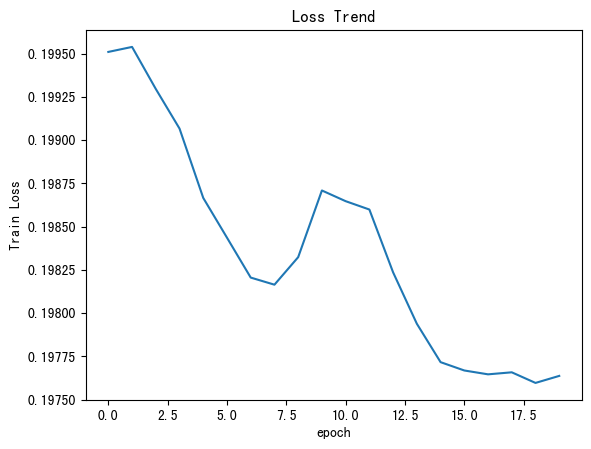

In [13]:
print(train_losses)
import numpy as np
import matplotlib.pyplot as plt

# 绘制数据编码趋势图
plt.plot(train_losses)

# 添加标题和标签
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('Train Loss')

# 显示图形
plt.show()